# 3D Classification Project

In [ ]:
! pip install pywavefront

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Library Import

In [ ]:
import numpy as np
import pandas as pd
import h5py
import zipfile
import pywavefront
import cv2
import shutil
import zipfile
import os
import zipfile
import gc
import copy
import math
import warnings
import random
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import albumentations as A
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import PIL
import torch.utils.data as data_utils
import xml.etree.ElementTree as ET # Parse XML Data.

from scipy import ndimage
from PIL import Image
from torch.utils.data import Dataset
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from torchvision import models, transforms
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder

In [ ]:
%matplotlib inline

In [ ]:
print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18171867443059731053
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13825277952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5626208438178483432
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Preparation

In [ ]:
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! kaggle datasets download -d daavoo/3d-mnist
! unzip ./3d-mnist

 99% 152M/153M [00:09<00:00, 20.0MB/s]
100% 153M/153M [00:09<00:00, 17.1MB/s]
Archive:  ./3d-mnist.zip
  inflating: full_dataset_vectors.h5  
  inflating: plot3D.py               
  inflating: test_point_clouds.h5    
  inflating: train_point_clouds.h5   
  inflating: voxelgrid.py            


## Data Preprocessing

Read OBJ Format

In [ ]:
def read_full_dataset(point_cloud_path = "./full_dataset_vectors.h5"):
  x_train = None
  y_train = None
  x_test = None
  y_test = None
  with h5py.File(point_cloud_path, "r") as hf:
    x_train = hf["X_train"][:]
    y_train = hf["y_train"][:]
    x_test = hf["X_test"][:]
    y_test = hf["y_test"][:]
    
    print(type(x_train))
    print(type(y_train))
    print(type(x_test))
    print(type(y_test))

    x_train = x_train.reshape(-1, 16, 16, 16)
    x_test = x_test.reshape(-1, 16, 16, 16)

  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = read_full_dataset()
print("Debugging Dataset...")
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Debugging Dataset...
(10000, 16, 16, 16)
(2000, 16, 16, 16)
(10000,)
(2000,)


Code some functions to transform the dataset

In [ ]:
def rotate_datum(datum, angle):
   datum = ndimage.rotate(datum, angle, reshape = False)
   return datum

# def add_noise(datum, noise):
#   datum = datum + noise
#   return datum

def train_transform_dataset(datum, label):
  random_rotation_angle = random.uniform(-20, 20)
  # random_noise_value = np.random.uniform(-0.0001, 0.0001, size = (16, 16, 16))

  datum = rotate_datum(datum, random_rotation_angle)
  # datum = add_noise(datum, random_noise_value)

  # datum = torch.from_numpy(datum)
  # label = torch.eye(label)[-1]

  return datum, label

Make Dataset Class for Pytorch

In [ ]:
class MNIST3DDataset(Dataset):
  def __init__(self, full_dataset_vector_path = "./full_dataset_vectors.h5", dataset_transform = None, is_train = True):
    super(MNIST3DDataset, self).__init__()
    self.full_dataset_vector_path = full_dataset_vector_path

    self.is_train = is_train
    if self.is_train:
      self.dataset = self.__load_train_dataset__()
    else:
      self.dataset = self.__load_test_dataset__()

    self.dataset_transform = dataset_transform
  
  def __load_train_dataset__(self):
    x_train = None
    y_train = None
    with h5py.File(self.full_dataset_vector_path, "r") as hf:
      x_train = hf["X_train"][:]
      y_train = hf["y_train"][:]

      x_train = x_train.reshape(-1, 16, 16, 16)

    return x_train, y_train

  def __load_test_dataset__(self):
    x_test = None
    y_test = None
    with h5py.File(self.full_dataset_vector_path, "r") as hf:
      x_test = hf["X_test"][:]
      y_test = hf["y_test"][:]

      x_test = x_test.reshape(-1, 16, 16, 16)

    return x_test, y_test

  def __getitem__(self, index):
    all_image_3d, all_labels = self.dataset

    image_3ds = all_image_3d.copy()
    labels = all_labels.copy()

    image_3d = image_3ds[index]
    label = labels[index]

    if self.dataset_transform is not None:
      image_3d, label = self.dataset_transform(image_3d, label)

    image_3d = torch.Tensor(image_3d).unsqueeze(0)
    image_3d[image_3d < 0.01] = 0
    label = torch.eye(10)[label]

    return (image_3d, label)

  def __len__(self):
    return len(self.dataset[0])

mnist_3d_train_dataset = MNIST3DDataset(
    dataset_transform = train_transform_dataset
)
mnist_3d_test_dataset = MNIST3DDataset(
    # dataset_transform = train_transform_dataset,
    is_train = False
)

print("Debugging MNIST Train Dataset: ")
print(len(mnist_3d_train_dataset))
print(mnist_3d_train_dataset[0][0].shape)
print(mnist_3d_train_dataset[0][1])

print("Debugging MNIST Validation Dataset: ")
print(len(mnist_3d_test_dataset))
print(mnist_3d_test_dataset[0][0].shape)
print(mnist_3d_test_dataset[0][1])

Debugging MNIST Train Dataset: 
10000
torch.Size([1, 16, 16, 16])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Debugging MNIST Validation Dataset: 
2000
torch.Size([1, 16, 16, 16])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


In [ ]:
mnist_3d_train_data_loader = torch.utils.data.DataLoader(
    mnist_3d_train_dataset,
    batch_size = 16,
)

mnist_3d_test_data_loader = torch.utils.data.DataLoader(
    mnist_3d_test_dataset,
    batch_size = 16,
)

for train_iteration, (images, labels) in enumerate(mnist_3d_train_data_loader):
  images = images.to(device)
  labels = labels.to(device)

  print(images.shape)
  print(labels.shape)

  break

for test_iteration, (images, labels) in enumerate(mnist_3d_test_data_loader):
  images = images.to(device)
  labels = labels.to(device)

  print(images.shape)
  print(labels.shape)

  break

torch.Size([16, 1, 16, 16, 16])
torch.Size([16, 10])
torch.Size([16, 1, 16, 16, 16])
torch.Size([16, 10])


Visualize the Dataset

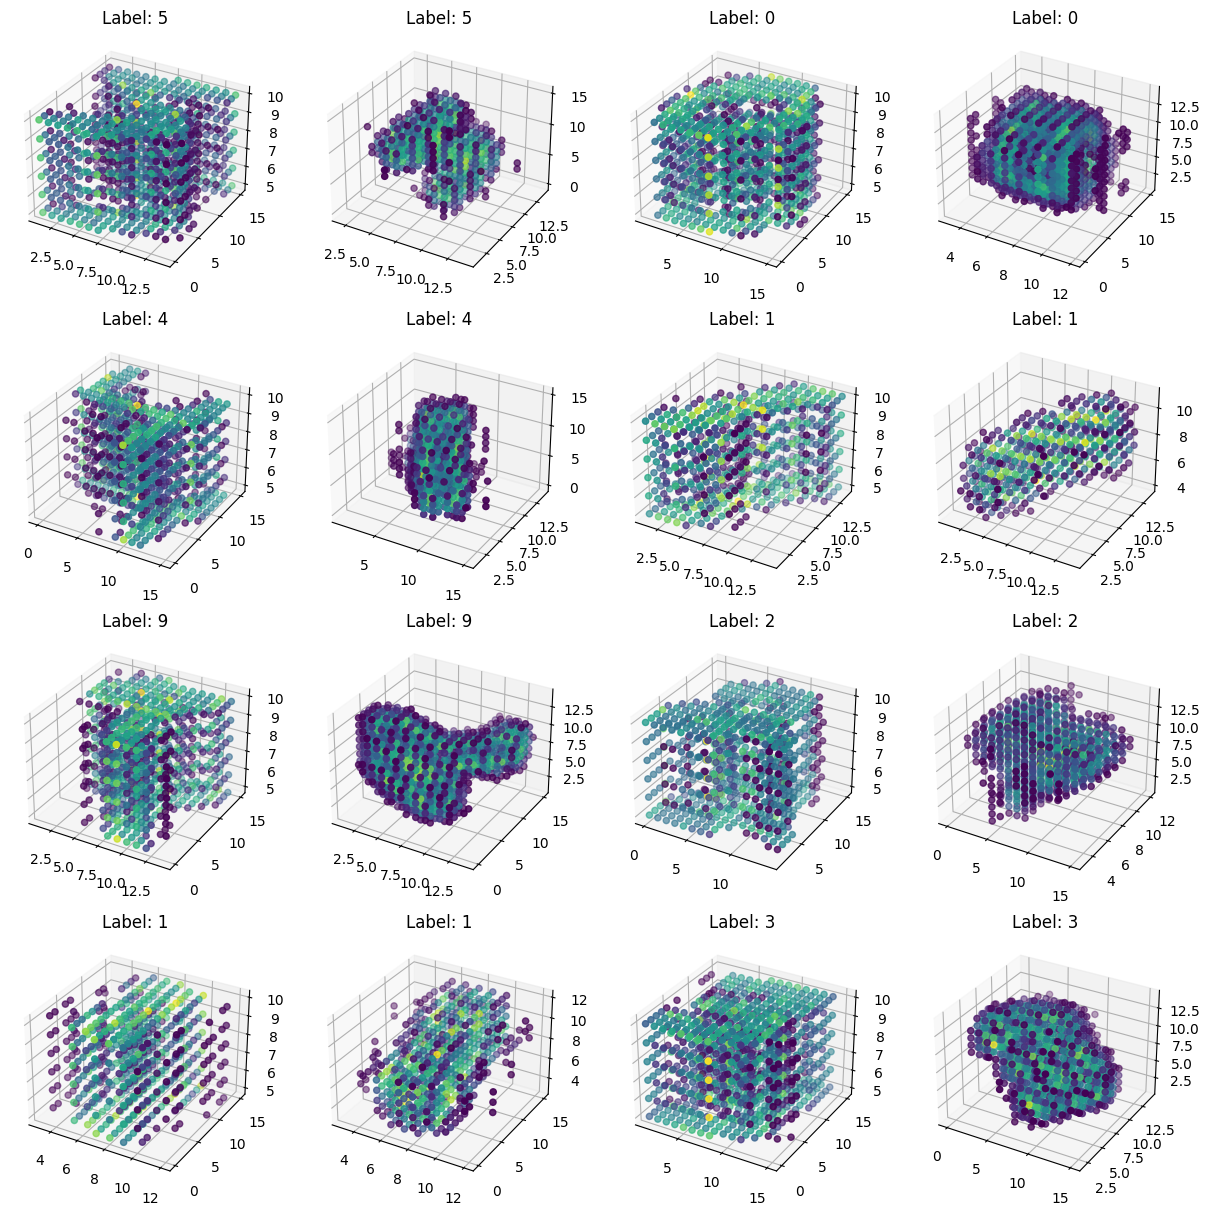

In [ ]:
N_ROWS = 4
N_COLS = 4

def get_ravel_3d_data(points, positive_value_threshold = 0.01):
  x, y, z = np.meshgrid(np.arange(16), np.arange(16), np.arange(16))

  points = points.ravel()
  x = x.ravel()
  y = y.ravel()
  z = z.ravel()

  filtered_indexes_for_positive_values = points > positive_value_threshold

  points = points[filtered_indexes_for_positive_values]
  x = x[filtered_indexes_for_positive_values]
  y = y[filtered_indexes_for_positive_values]
  z = z[filtered_indexes_for_positive_values]

  return points, x, y, z

fig, axes = plt.subplots(
  nrows = N_ROWS, 
  ncols = N_COLS, 
  figsize = (15, 15), 
  subplot_kw = dict(projection='3d')
)

for index, (points, labels) in enumerate(mnist_3d_train_dataset):
  row_index = int(index / N_COLS)
  col_index = index % N_COLS

  points, x, y, z = get_ravel_3d_data(points, 0)

  # Get the maximum value of all output neurons.
  predicted = np.argmax(labels)

  ax = axes[row_index][col_index]
  ax.set_title(f"Label: {predicted}")
  ax.scatter(x, y, z, c = points)
  
  if index == (N_ROWS * N_COLS) - 1:
    break


Do the same one, but with Plotly

In [ ]:
N_ROWS = 4
N_COLS = 4

fig_2 = make_subplots(
  rows = N_ROWS, 
  cols = N_COLS, 
  specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, 
          {'type': 'scatter3d'}, {'type': 'scatter3d'}],
         [{'type': 'scatter3d'}, {'type': 'scatter3d'}, 
          {'type': 'scatter3d'}, {'type': 'scatter3d'}],
         [{'type': 'scatter3d'}, {'type': 'scatter3d'}, 
          {'type': 'scatter3d'}, {'type': 'scatter3d'}],
         [{'type': 'scatter3d'}, {'type': 'scatter3d'}, 
          {'type': 'scatter3d'}, {'type': 'scatter3d'}],
         ]
)

for index, (points, label) in enumerate(mnist_3d_train_dataset):
  row_index = int(index / N_COLS) + 1
  col_index = (index % N_COLS) + 1

  points, x, y, z = get_ravel_3d_data(points)

  # Get the maximum value of all output neurons.
  predicted = np.argmax(label)
  
  fig_2.add_trace(go.Scatter3d(x=x, y=y, z=z, text = f"Data Label: {predicted}", mode='markers', 
                            marker=dict(size=3, color=points, colorscale='Viridis'), showlegend = False), 
                row = row_index, col = col_index)

  fig_2.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='MNIST 3D Dataset Visualization', width=1000, height=800)
  
  if index == (N_ROWS * N_COLS) - 1:
    break

fig_2.show()

## Data Modelling

Make the CNN model for classifying 3D networks.

In [ ]:
class MNIST3DClassifierModel(nn.Module):
  def __init__(self):
    super(MNIST3DClassifierModel, self).__init__()

    # We calculate this formula for padding.
    # NOTES: Filter_size = kernel_size
    # In this case, we use same padding, the formula is: [(filter_size  - 1) / 2] ( Same Padding--> input size = output size).

    # Formula of feature map size: [(input_size - filter_size + 2(padding) / stride) + 1]
    # Output after conv1: [(16 - 3 + 2 (1) / 1) + 1] = 28
    # Output after MaxPool1 = 28 / 2 = 14

    # 16 x 16
    self.conv_1 = nn.Sequential(
        nn.Conv3d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
        nn.MaxPool3d(2),
        nn.ReLU(),
    )
    # 8 x 8
    self.conv_2 = nn.Sequential(
        nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
        nn.MaxPool3d(2),
        nn.ReLU(),
    )
    
    # 4 x 4
    self.conv_3 = nn.Sequential(
        nn.Conv3d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
        nn.MaxPool3d(2),
        nn.ReLU(),
    )

    # 2 x 2
    self.fc1 = nn.Sequential(
      nn.Flatten(),
      nn.Linear(128 * 2 * 2 * 2, 512),
    )
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

mnist_3d_classifier_model = MNIST3DClassifierModel().to(device)
mnist_3d_classifier_model

MNIST3DClassifierModel(
  (conv_1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv_2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv_3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=512, bias=True)
  )
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

Train the model.

In [ ]:
n_epochs = 10
train_losses = []
val_losses = []

mnist_3d_classifier_model = MNIST3DClassifierModel().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_3d_classifier_model.parameters(), lr=0.0001)

for current_epoch in range(n_epochs):
  # total_loss = 0
  
  for train_iteration, (images, labels) in enumerate(mnist_3d_train_data_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    
    outputs = mnist_3d_classifier_model(images)
    loss = loss_function(outputs, labels)

    loss.backward()
    optimizer.step()

    if train_iteration % 10 == 0:
      print(f"Epochs: {current_epoch} / {n_epochs}, Iteration: {train_iteration}, loss: {loss.item()}")

  with torch.no_grad():
    correct = 0
    total = 0
    for test_iteration, (images, labels) in enumerate(mnist_3d_test_data_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = mnist_3d_classifier_model(images)
      loss = loss_function(outputs, labels)

      # Get the label size to total variable. 
      total += labels.size(0)

      # Accumulate the number of correct predictions.
      correct += (outputs == labels).sum().item()

      if test_iteration % 10 == 0:
        print(f"(Validation) Epochs: {current_epoch} / {n_epochs}, Iteration: {test_iteration}, loss: {loss.item()}")
        print(f"Validation Accuracy: {(correct / total) * 100} ")
        correct = 0
        total = 0

Epochs: 0 / 10, Iteration: 0, loss: 2.293137550354004
Epochs: 0 / 10, Iteration: 10, loss: 2.3149824142456055
Epochs: 0 / 10, Iteration: 20, loss: 2.3148374557495117
Epochs: 0 / 10, Iteration: 30, loss: 2.349978446960449
Epochs: 0 / 10, Iteration: 40, loss: 2.2634096145629883
Epochs: 0 / 10, Iteration: 50, loss: 2.332014322280884
Epochs: 0 / 10, Iteration: 60, loss: 2.2918519973754883
Epochs: 0 / 10, Iteration: 70, loss: 2.2951347827911377
Epochs: 0 / 10, Iteration: 80, loss: 2.299490451812744
Epochs: 0 / 10, Iteration: 90, loss: 2.352605104446411
Epochs: 0 / 10, Iteration: 100, loss: 2.28240966796875
Epochs: 0 / 10, Iteration: 110, loss: 2.2828550338745117
Epochs: 0 / 10, Iteration: 120, loss: 2.253783702850342
Epochs: 0 / 10, Iteration: 130, loss: 2.13096022605896
Epochs: 0 / 10, Iteration: 140, loss: 2.1699538230895996
Epochs: 0 / 10, Iteration: 150, loss: 2.279442071914673
Epochs: 0 / 10, Iteration: 160, loss: 2.362675428390503
Epochs: 0 / 10, Iteration: 170, loss: 2.32564854621887

Save the model.

In [ ]:
def save_model(model, optimizer, filename = "model.pth.tar"):
  print("Saving model...")
  checkpoint = {
      "model_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict()
  }
  torch.save(checkpoint, filename)
  print("Finished saving model!")

directory_path = "./drive/MyDrive/Models"
save_model(mnist_3d_classifier_model, optimizer, filename = f"{directory_path}/mnist_3d_classifier_model.pth.tar")

Saving model...
Finished saving model!


In [ ]:
def load_model(model, optimizer, filename = "model.pth.tar"):
  print("Loading model...")
  checkpoint = torch.load(filename)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print("Finished loading model!")

  return model, optimizer

directory_path = "./drive/MyDrive/Models"
mnist_3d_classifier_model =  MNIST3DClassifierModel().to(device)
optimizer = optim.Adam(mnist_3d_classifier_model.parameters(), lr=0.0001)
mnist_3d_classifier_model, optimizer = load_model(
    mnist_3d_classifier_model, optimizer, f"{directory_path}/mnist_3d_classifier_model.pth.tar"
)

Loading model...
Finished loading model!


Check classifier results from sample validation data.

In [61]:
with torch.no_grad():
  max_test_iteration = 16
  N_ROWS = 4
  N_COLS = 4

  fig = make_subplots(
    rows = N_ROWS, 
    cols = N_COLS, 
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, 
            {'type': 'scatter3d'}, {'type': 'scatter3d'}],
          [{'type': 'scatter3d'}, {'type': 'scatter3d'}, 
            {'type': 'scatter3d'}, {'type': 'scatter3d'}],
          [{'type': 'scatter3d'}, {'type': 'scatter3d'}, 
            {'type': 'scatter3d'}, {'type': 'scatter3d'}],
          [{'type': 'scatter3d'}, {'type': 'scatter3d'}, 
            {'type': 'scatter3d'}, {'type': 'scatter3d'}],
          ]
  )

  for test_iteration, (point, label) in enumerate(mnist_3d_test_dataset):
    row_index = int(test_iteration / N_COLS) + 1
    col_index = (test_iteration % N_COLS) + 1

    point = point.unsqueeze(0).to(device)
    label = label.unsqueeze(0).to(device)

    outputs = mnist_3d_classifier_model(point)

    point, x, y, z = get_ravel_3d_data(point.cpu())

    # Get the maximum value of all output neurons.
    _, predicted = torch.max(outputs.data, 1)
    _, expected = torch.max(label.data, 1)

    point = point.squeeze(0)
    predicted = predicted[0].cpu().numpy()
    expected = expected[0].cpu().numpy()
    
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, text = f"{str(predicted)}, expected: {str(expected)}", mode='markers', 
                              marker=dict(size=3, color=point, colorscale='Viridis'), showlegend = False), 
                  row = row_index, col = col_index)

    fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                    title='MNIST 3D Dataset Visualization', width=1000, height=800)
    
    if test_iteration == (N_ROWS * N_COLS) - 1:
      break

  fig.show()